In [1]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch
import numpy as np

model = RobertaForMaskedLM.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/home/yluo147/anaconda3/envs/laser/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
layers = []

for i in range(12):
    query_weight = model.roberta.encoder.layer[i].attention.self.query.weight
    key_weight = model.roberta.encoder.layer[i].attention.self.key.weight
    value_weight = model.roberta.encoder.layer[i].attention.self.value.weight
    dense_weight = model.roberta.encoder.layer[i].attention.output.dense.weight
    
    #stack the weights
    weights = torch.stack([query_weight, key_weight, value_weight, dense_weight])
    layers.append(weights)

In [4]:
layers[0].shape

torch.Size([4, 768, 768])

In [56]:
import tensorly as tl
from tensorly.decomposition import parafac

In [57]:
tl.set_backend('pytorch')

In [58]:
from IPython.display import display, clear_output


In [59]:
%matplotlib inline

In [60]:
import matplotlib.pyplot as plt

In [61]:
colors = [
    'red', 'green', 'blue', 'orange', 'purple',
    'cyan', 'magenta', 'yellow', 'black', 'lime',
    'pink', 'brown'
]

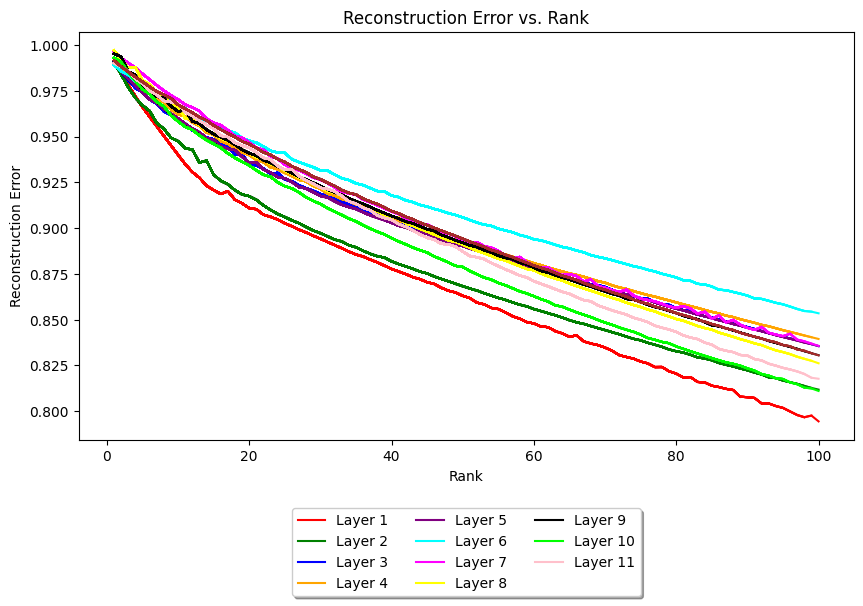

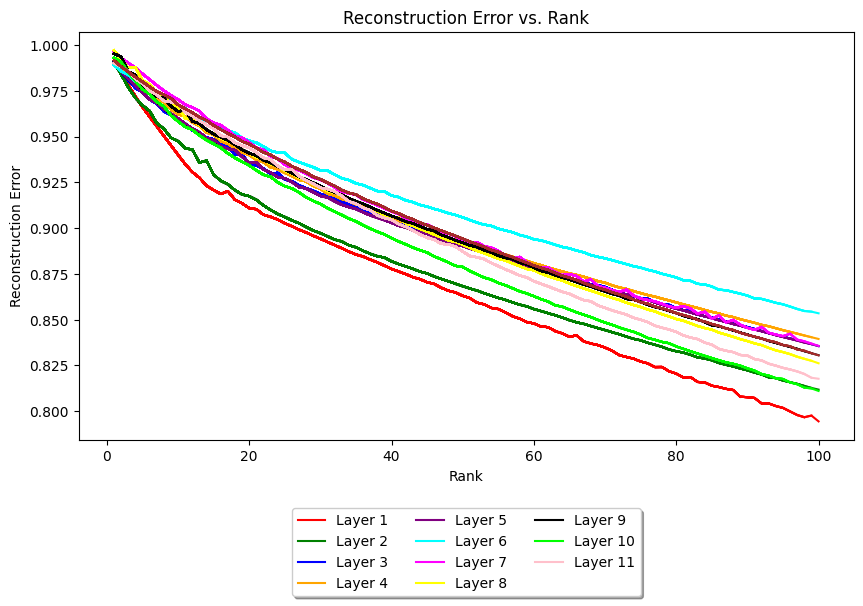

In [62]:
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from IPython.display import display, clear_output

reconstruction_error = []

plt.figure(figsize=(10, 6))

for i in range(12):  # Loop through each layer
    errors = []
    for r in range(1, 101):  # Loop through ranks 1 to 100
        tensorly_Tensor = tl.tensor(layers[i], device='cuda')
        
        # Decompose the tensor using PARAFAC
        factors = parafac(tensorly_Tensor, rank=r, init='random')
        
        # Reconstruct the tensor from its factors
        rec = tl.kruskal_to_tensor(factors)
        
        # Calculate the relative reconstruction error
        error = tl.norm(tensorly_Tensor.cpu() - rec.cpu()) / tl.norm(tensorly_Tensor.cpu())
        errors.append(error)
        
        clear_output(wait=True)
        
        plt.plot(range(1, r+1), errors, color=colors[i])
        plt.xlabel('Rank')
        plt.ylabel('Reconstruction Error')
        plt.title('Reconstruction Error vs. Rank')
        plt.subplots_adjust(bottom=0.2)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=3)

        if r==100:
            plt.plot([], [], color=colors[i], label=f'Layer {i+1}')
       
        # Display the updated plot
        display(plt.gcf())

    reconstruction_error.append(errors)

# Note: Saving the plot after real-time updates will only save the last state of the plot
plt.savefig('roberta_reconstruction_error.png')
